# Project description
Through this document, we will try to understand why our best and most experienced employees are leaving the company prematurely. 
We have this database with ten variables and ten thousand observations. Our challege consists in guessing the reasons behind their leaving and to predict which valuable employees will leave next. 

# Data preparation
### Loading the necessary libraries

In [1]:
library(dplyr)
library(lattice)
library(ggplot2)
library(corrplot)
library(Matrix)
library(foreach)
library(MASS)
library(glmnet)
library(rpart)
library(randomForest)
library(caret)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loaded glmnet 2.0-10

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



### Reading data

In [2]:
hr<-read.csv("../input/HR_comma_sep.csv",sep=",")
dim(hr)

[1] 14999    10

### Transforming Data

In [3]:
## transform the factor variables into numeric data
## relevel the salary variable
levels(hr$salary)<-c("low","medium","high")
hr$salary<-as.numeric(hr$salary)

## transform left variable to factor
hr$left<-as.factor(hr$left)
str(hr)

'data.frame':	14999 obs. of  10 variables:
 $ satisfaction_level   : num  0.38 0.8 0.11 0.72 0.37 0.41 0.1 0.92 0.89 0.42 ...
 $ last_evaluation      : num  0.53 0.86 0.88 0.87 0.52 0.5 0.77 0.85 1 0.53 ...
 $ number_project       : int  2 5 7 5 2 2 6 5 5 2 ...
 $ average_montly_hours : int  157 262 272 223 159 153 247 259 224 142 ...
 $ time_spend_company   : int  3 6 4 5 3 3 4 5 5 3 ...
 $ Work_accident        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ left                 : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ promotion_last_5years: int  0 0 0 0 0 0 0 0 0 0 ...
 $ sales                : Factor w/ 10 levels "accounting","hr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ salary               : num  2 3 3 2 2 2 2 2 2 2 ...


We have 14999 observations with 10 variables. And the database is really clean, there is no missing values in any variable. 

### Validation Dataset
To have a correct jugement about our algorithm's accuracy, we will divide the dataset into a training set and a validation set. 

In [4]:
set.seed(7)
validationIndex<-createDataPartition(hr$left,p=0.7,list=F)
train<-hr[validationIndex,]
validation<-hr[-validationIndex,]

## Exploratory analysis
### Descriptive Statistics

In [5]:
table(train$left)
percentage<-table(train$left)[2]/nrow(train)*100
percentage


   0    1 
8000 2500 

1 
23.80952

We can see that over 10500 employees, 23% left the company.

In [6]:
summary(hr)

 satisfaction_level last_evaluation  number_project  average_montly_hours
 Min.   :0.0900     Min.   :0.3600   Min.   :2.000   Min.   : 96.0       
 1st Qu.:0.4400     1st Qu.:0.5600   1st Qu.:3.000   1st Qu.:156.0       
 Median :0.6400     Median :0.7200   Median :4.000   Median :200.0       
 Mean   :0.6128     Mean   :0.7161   Mean   :3.803   Mean   :201.1       
 3rd Qu.:0.8200     3rd Qu.:0.8700   3rd Qu.:5.000   3rd Qu.:245.0       
 Max.   :1.0000     Max.   :1.0000   Max.   :7.000   Max.   :310.0       
                                                                         
 time_spend_company Work_accident    left      promotion_last_5years
 Min.   : 2.000     Min.   :0.0000   0:11428   Min.   :0.00000      
 1st Qu.: 3.000     1st Qu.:0.0000   1: 3571   1st Qu.:0.00000      
 Median : 3.000     Median :0.0000             Median :0.00000      
 Mean   : 3.498     Mean   :0.1446             Mean   :0.02127      
 3rd Qu.: 4.000     3rd Qu.:0.0000             3rd Qu.:0.00000 

### Unimodel Data Visualizations
We will analyse the variable compared with the situation of leaving or staying in the company. 0 means staying, 1 means leaving.

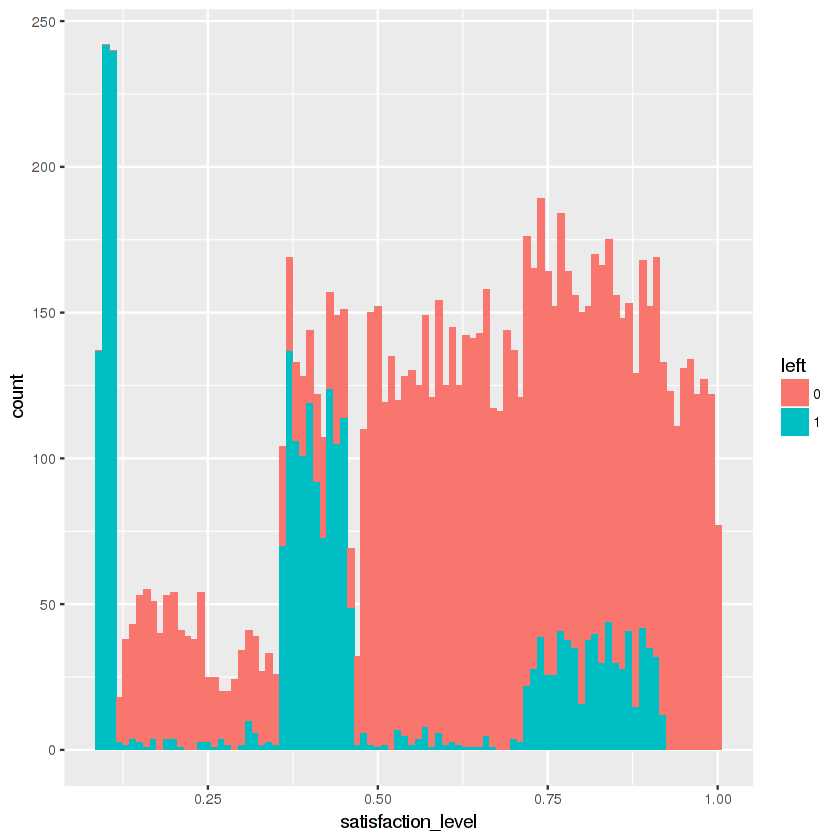

In [7]:
qplot(satisfaction_level,data=train,fill=left,binwidth=0.01)

We can observe that people leaving the company have a low percentage of satisfaction.

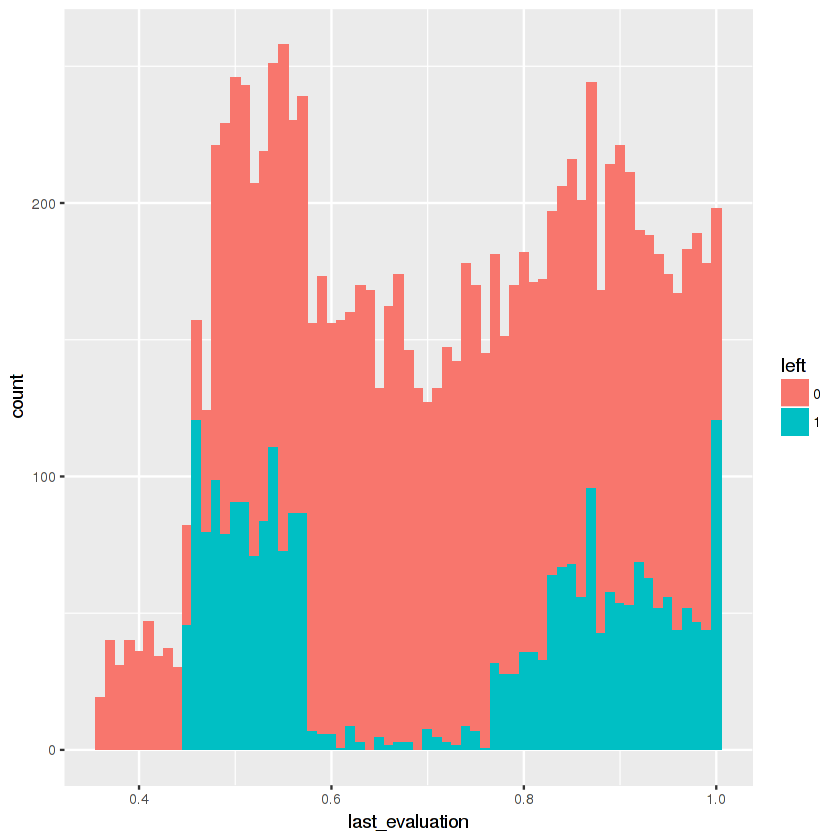

In [8]:
qplot(last_evaluation,data=train,fill=left,binwidth=0.01)

A great part of people who leave the company score high in their last evaluation.

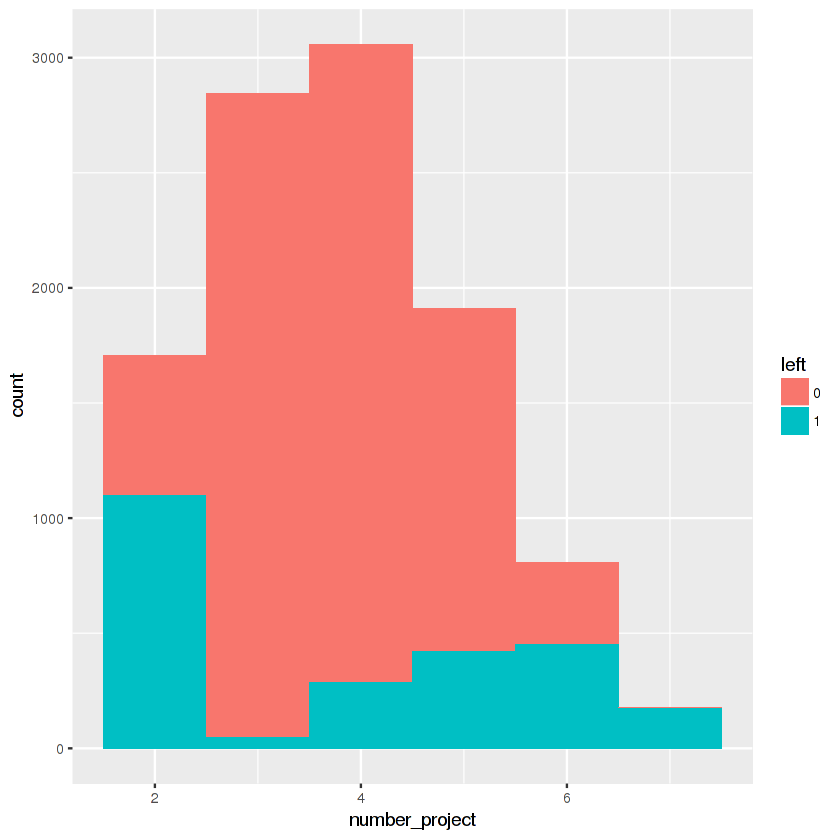

In [9]:
qplot(number_project,data=train,fill=left,binwidth=1)

A great part of them have a large number of projects to attend to.   

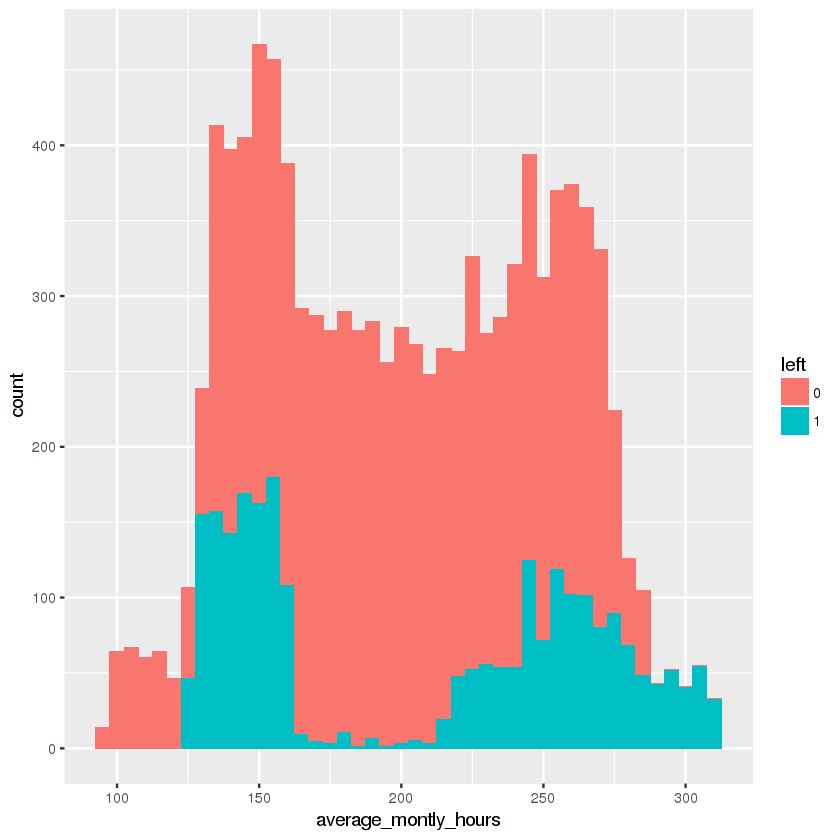

In [10]:
qplot(average_montly_hours,data=train,fill=left,binwidth=5)

We can see that a large part of people leaving the company worked more than 200 hours per month on average.  

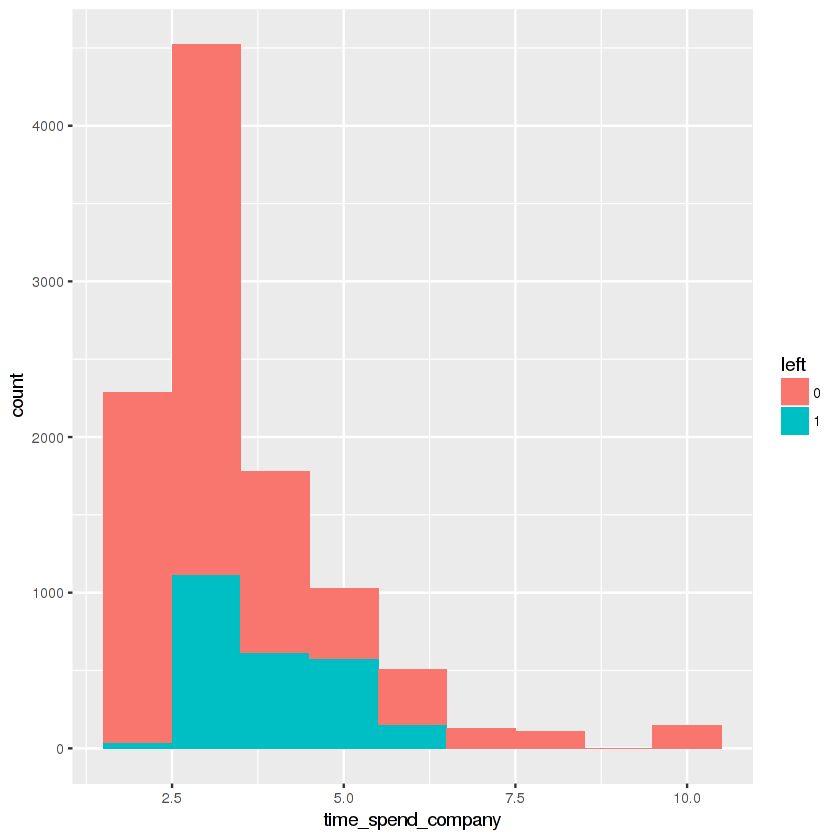

In [11]:
qplot(time_spend_company,data=train,fill=left,binwidth=1)

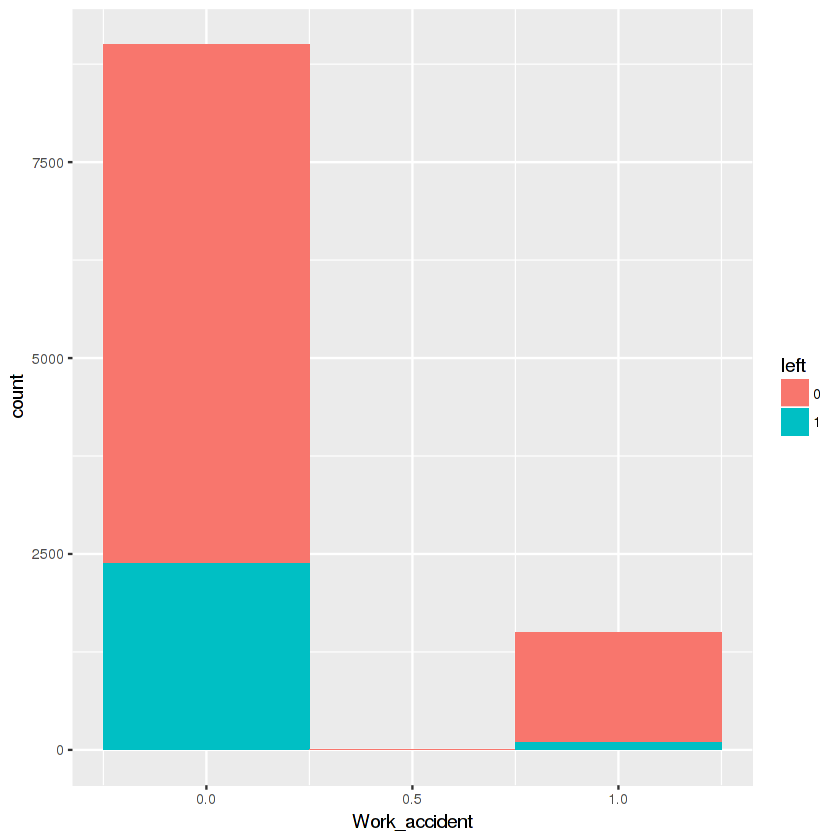

In [12]:
qplot(Work_accident,data=train,fill=left,binwidth=0.5)

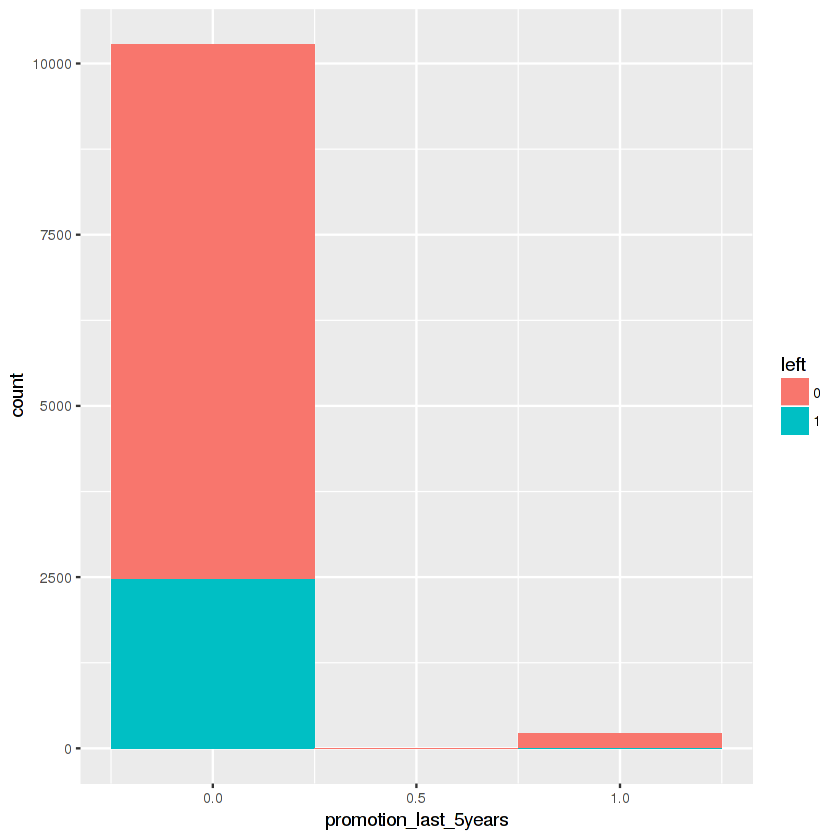

In [13]:
qplot(promotion_last_5years,data=train,fill=left,binwidth=0.5)

They nearly have no promotion during the last five years.

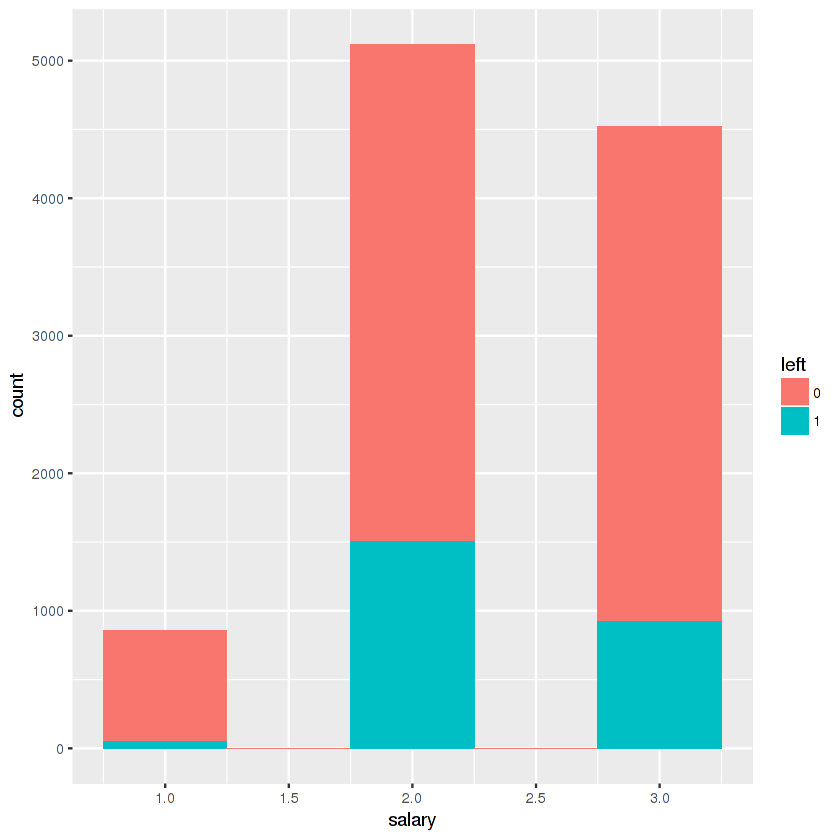

In [14]:
qplot(salary,data=train,fill=left,binwidth=0.5)

They generally have medium or high salary.

With this first analysis, we could see that the employees leaving the company are generally not so satisfied with their situation, work on many projects, work a lot and have a high evaluation, but they didn't get a promotion in the last year, and have rather high salaries. 

### Correlation Data Visualizations
We will see the correlation between the variables. 

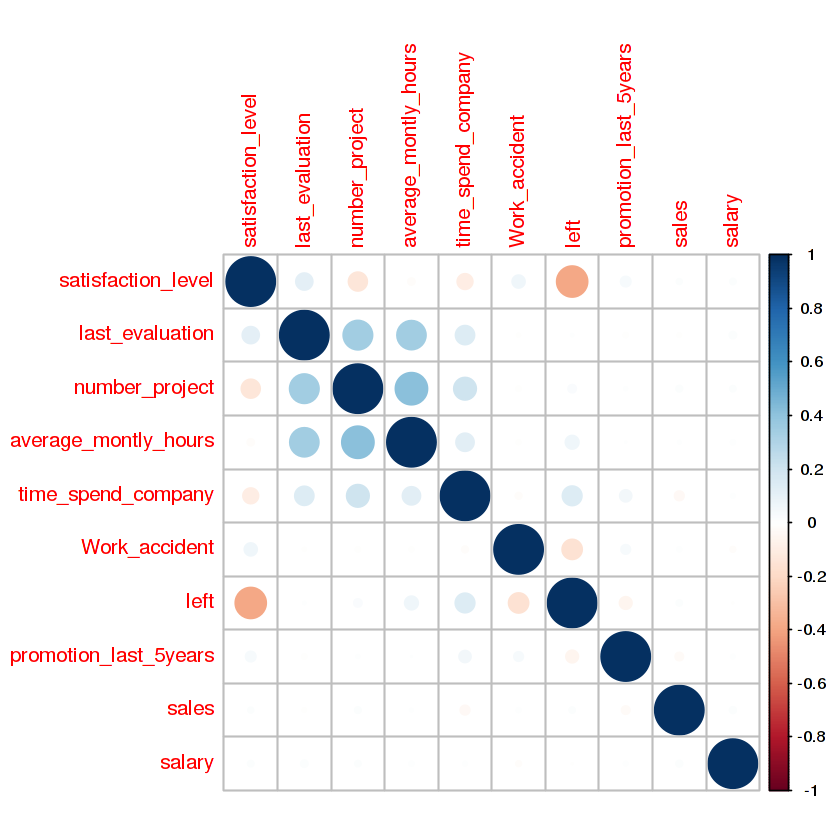

In [15]:
## we first exclure the left variable, and the last two variables. 
## correlation plot
train_sub<-train
train_sub$sales<-as.numeric(train_sub$sales)
train_sub$left<-as.numeric(train_sub$left)
correlations<-cor(train_sub)
corrplot(correlations,method="circle")

We observe that the satisfaction level have a positive correlation with the "left" variable. the variables number_project and time_spend_company have a slightly positive relationship with the "left" variable. 
Some slightly positve correlation between "number project" and "last evaluation","average montly hours" and "last evaluation", "average montly hours" and "number project".

## Finding the best algorithm
### Tesing several algorithms
To find the best algorithm, we will test several. 


Call:
summary.resamples(object = results)

Models: GLM, IDA, GLMNET, CART, KNN, RF 
Number of resamples: 30 

Accuracy 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
GLM    0.7447619 0.7585714 0.7642857 0.7647302 0.7721429 0.7809524    0
IDA    0.7428571 0.7571429 0.7619048 0.7623175 0.7697619 0.7809524    0
GLMNET 0.7714286 0.7840476 0.7885714 0.7903810 0.7980952 0.8066667    0
CART   0.8942857 0.9052381 0.9338095 0.9233651 0.9395238 0.9466667    0
KNN    0.9247619 0.9304762 0.9352381 0.9356190 0.9407143 0.9476190    0
RF     0.9847619 0.9869048 0.9895238 0.9897143 0.9921429 0.9961905    0

Kappa 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
GLM    0.1167608 0.1964996 0.2120126 0.2115554 0.2363950 0.2662948    0
IDA    0.1346863 0.1972177 0.2146290 0.2145000 0.2359196 0.2752294    0
GLMNET 0.1807407 0.2456854 0.2572878 0.2626815 0.2890185 0.3280522    0
CART   0.6741227 0.7120872 0.8242164 0.7805578 0.8382110 0.8579903    0
KNN    

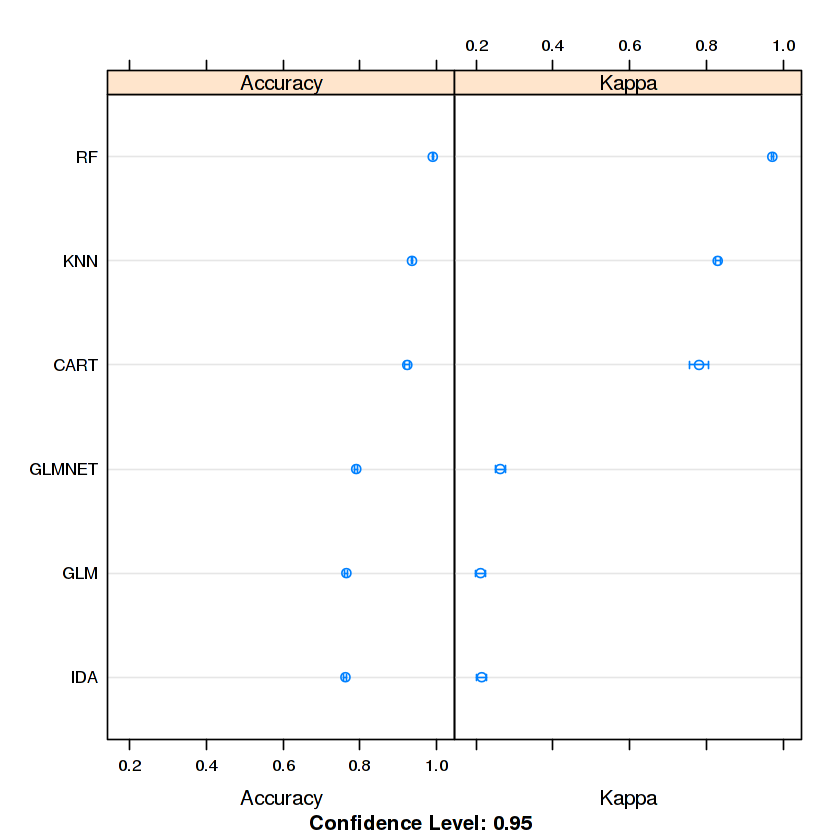

In [16]:
## Run algorithms using 10-fole cross validation
trainControl<-trainControl(method = "repeatedcv",number=10,repeats = 3)
metric<-"Accuracy"
## Logistic regression
set.seed(5)
fit.glm<-train(left~., data=train, method="glm", metric=metric, trControl=trainControl)
## LDA linear Discriminate Analysis
set.seed(5)
fit.lda<-train(left~., data=train, method="lda", metric=metric, trControl=trainControl)
## GLMNET regularized Logistic Regression
set.seed(5)
fit.glmnet<-train(left~., data=train, method="glmnet", metric=metric, trControl=trainControl)
## KNN
set.seed(5)
fit.knn<-train(left~., data=train, method="knn", metric=metric, trControl=trainControl)
## CART
set.seed(5)
fit.cart<-train(left~., data=train, method="rpart", metric=metric, trControl=trainControl)
## RF
set.seed(5)
fit.rf<-train(left~., data=train, method="rf", metric=metric, trControl=trainControl)

results<-resamples(list(GLM=fit.glm,IDA=fit.lda,GLMNET=fit.glmnet, CART=fit.cart, KNN=fit.knn,RF=fit.rf))
summary(results)
dotplot(results)

We could see that the random forest algorithm has the best accuracy which is 98.9%, then comes the Classification and regression trees (92.3%) and 3rd the K Nearest neigbors (93.5%)

### Algorithms Tuning
We will tune the KNN and Classification Tree algorithms to see if we get a better accuracy.

k-Nearest Neighbors 

10500 samples
    9 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 9450, 9450, 9450, 9450, 9450, 9450, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9498095  0.8662273
   2  0.9320952  0.8213436
   3  0.9327937  0.8237235
   4  0.9307937  0.8180664
   5  0.9332063  0.8236931
   6  0.9337460  0.8248654
   7  0.9354921  0.8287922
   8  0.9357143  0.8297297
   9  0.9353016  0.8290290
  10  0.9351429  0.8286408
  11  0.9348254  0.8279239
  12  0.9340317  0.8258324
  13  0.9340000  0.8257113
  14  0.9334921  0.8244558
  15  0.9329206  0.8232724
  16  0.9326349  0.8225759
  17  0.9325397  0.8223195
  18  0.9323175  0.8218952
  19  0.9324127  0.8221436
  20  0.9312698  0.8193604

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was k = 1.


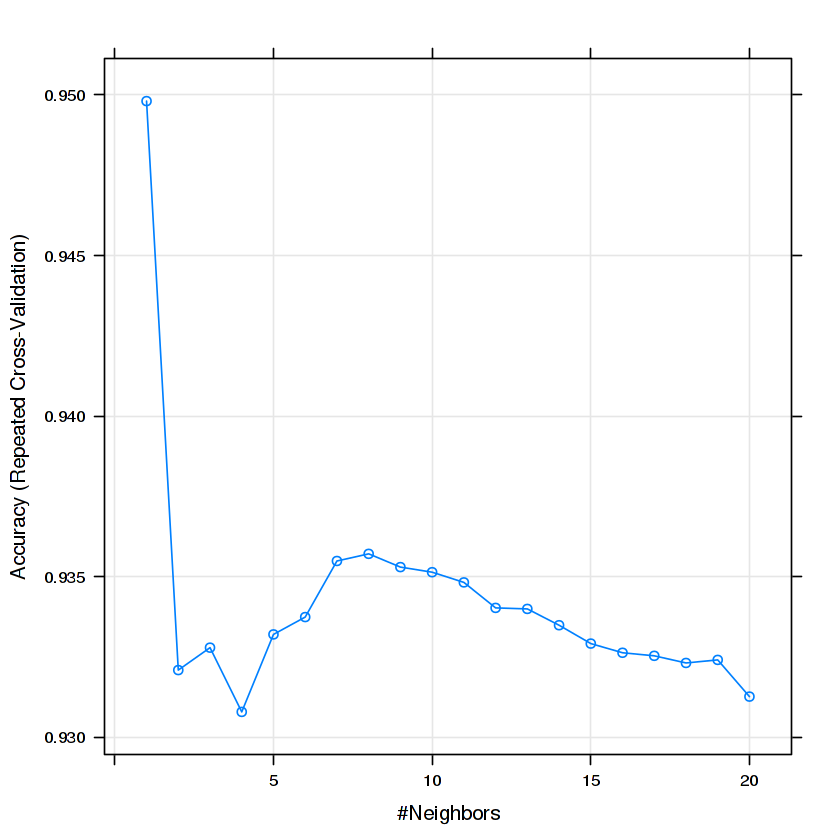

In [17]:
## KNN
set.seed(5)
grid<-expand.grid(.k=seq(1,20,by=1))
fit.knn2<-train(left~., data=train, method="knn", metric=metric, tuneGrid=grid,trControl=trainControl)
print(fit.knn2)
plot(fit.knn2)

We can see that when we tried k=1, we got a better accuracy.

In [18]:
set.seed(5)
grid<-expand.grid(.k=1)
fit.knn2<-train(left~., data=train, method="knn", metric=metric, tuneGrid=grid,trControl=trainControl)

CART 

10500 samples
    9 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 9450, 9450, 9450, 9450, 9450, 9450, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.9756190  0.9315006
  0.05  0.9550794  0.8772199
  0.10  0.9082857  0.7223754

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was cp = 0.


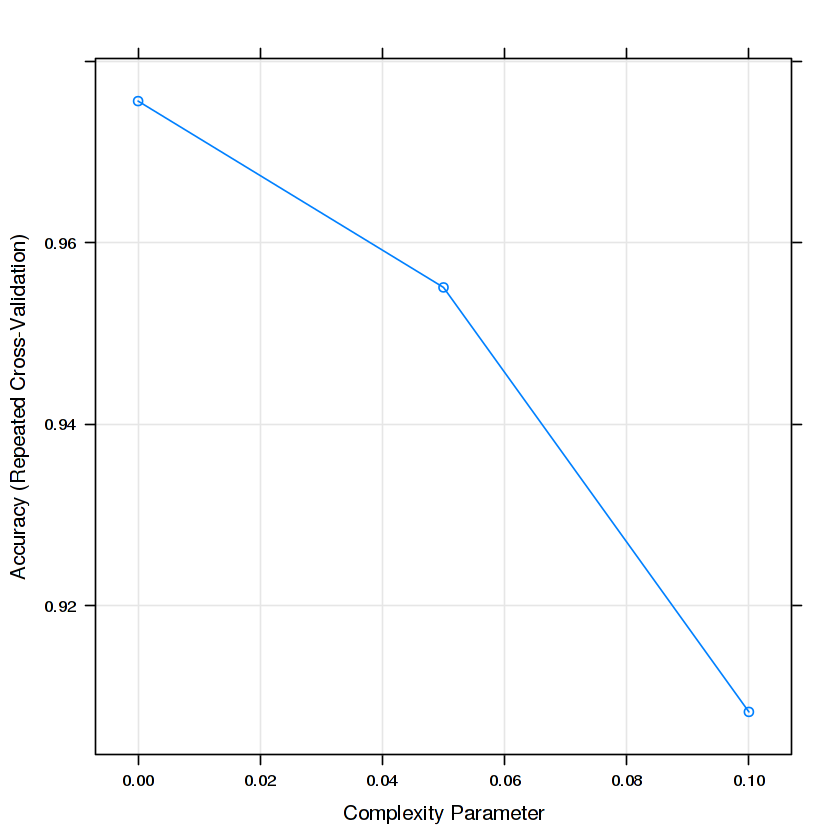

In [19]:
## CART
set.seed(5)
grid2<-expand.grid(.cp=c(0,0.05,0.1))
fit.rpart2<-train(left~., data=train, method="rpart", metric=metric, tuneGrid=grid2,trControl=trainControl)
print(fit.rpart2)
plot(fit.rpart2)

We choose cp=0 to get a better accuracy

In [20]:
set.seed(5)
grid2<-expand.grid(.cp=c(0,0))
fit.cart2<-train(left~., data=train, method="rpart", metric=metric, tuneGrid=grid2,trControl=trainControl)

## Prediction
### Model KNN

In [21]:
## model Knn
predict.knn<-predict(fit.knn,newdata=validation[,-7])
conf.knn<-confusionMatrix(validation$left,predict.knn)
conf.knn$overall[1]
conf.knn$table

predict.knn2<-predict(fit.knn2,newdata=validation[,-7])
conf.knn2<-confusionMatrix(validation$left,predict.knn2)
conf.knn2$overall[1]
conf.knn2$table

Accuracy 
0.936208

          Reference
Prediction    0    1
         0 3223  205
         1   82  989

Accuracy 
0.9517671

          Reference
Prediction    0    1
         0 3249  179
         1   38 1033

We have a better accuracy in using the tuned KNN model.

### Model CART

In [22]:
## model CART
predict.cart<-predict(fit.cart,newdata=validation[,-7])
conf.cart<-confusionMatrix(validation$left,predict.cart)
conf.cart$overall[1]
conf.cart$table

predict.cart2<-predict(fit.cart2,newdata=validation[,-7])
conf.cart2<-confusionMatrix(validation$left,predict.cart2)
conf.cart2$overall[1]
conf.cart2$table

Accuracy 
0.9102023

          Reference
Prediction    0    1
         0 3375   53
         1  351  720

Accuracy 
0.9757724

          Reference
Prediction    0    1
         0 3407   21
         1   88  983

### Model Random Forest

In [23]:
## model RF
predict.rf<-predict(fit.rf,newdata=validation[,-7])
conf.rf<-confusionMatrix(validation$left,predict.rf)
conf.rf$overall[1]
conf.rf$table

Accuracy 
0.9919982

          Reference
Prediction    0    1
         0 3420    8
         1   28 1043

We have 99% accuracy in using the random forest model. But this algorithms take a lot of computing time. We may prefer to choose the KNN model with its 95% accuracy, which runs way faster.